In [153]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.metrics import mean_absolute_error, mean_squared_error

tf.__version__

'2.11.0'

In [33]:
# Load dataset
csv_file = '../Dataset/dataset_augmented.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,484.4822,350.23
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50
3,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,774.6917,347.50
4,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,4,644.6140,364.11


In [128]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']
nsubs_df = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917
3,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,774.6917
4,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140


2
64
272
80
80


(array([  2.,  64., 272.,  80.,  80.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

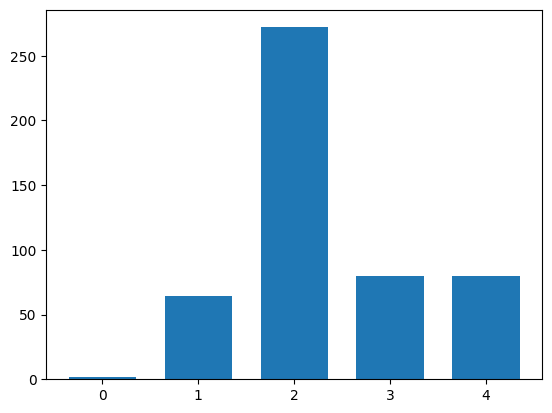

In [129]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [36]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,498.0,0.353414,0.959753,0.00000,0.0000,0.0000,0.0000,4.0000
Pos2,498.0,0.427711,1.080183,0.00000,0.0000,0.0000,0.0000,4.0000
Pos3,498.0,0.363454,0.990107,0.00000,0.0000,0.0000,0.0000,4.0000
Pos4,498.0,0.331325,0.943400,0.00000,0.0000,0.0000,0.0000,4.0000
Pos5,498.0,0.383534,1.000749,0.00000,0.0000,0.0000,0.0000,4.0000
Pos6,498.0,0.321285,0.917738,0.00000,0.0000,0.0000,0.0000,4.0000
Pos7,498.0,0.339357,0.946930,0.00000,0.0000,0.0000,0.0000,4.0000
Pos8,498.0,0.417671,1.022016,0.00000,0.0000,0.0000,0.0000,4.0000
Pos9,498.0,0.417671,1.022016,0.00000,0.0000,0.0000,0.0000,4.0000
Pos10,498.0,0.339357,0.946930,0.00000,0.0000,0.0000,0.0000,4.0000


In [130]:
# remove data with R~8

nsubs_df = nsubs_df[ dataframe['target']>10 ]
dataframe = dataframe[ dataframe['target']>10 ]
print(dataframe.describe().transpose())

# remove data with target<390
nsubs_df = nsubs_df[ dataframe['target']>390 ]
dataframe = dataframe[ dataframe['target']>390 ]
print(dataframe.describe().transpose())

        count        mean        std       min         25%        50%  \
Pos1    496.0    0.354839   0.961426    0.0000    0.000000    0.00000   
Pos2    496.0    0.429435   1.082020    0.0000    0.000000    0.00000   
Pos3    496.0    0.364919   0.991835    0.0000    0.000000    0.00000   
Pos4    496.0    0.318548   0.922961    0.0000    0.000000    0.00000   
Pos5    496.0    0.381048   0.999982    0.0000    0.000000    0.00000   
Pos6    496.0    0.322581   0.919362    0.0000    0.000000    0.00000   
Pos7    496.0    0.340726   0.948595    0.0000    0.000000    0.00000   
Pos8    496.0    0.413306   1.017297    0.0000    0.000000    0.00000   
Pos9    496.0    0.413306   1.017297    0.0000    0.000000    0.00000   
Pos10   496.0    0.340726   0.948595    0.0000    0.000000    0.00000   
Pos11   496.0    0.322581   0.919362    0.0000    0.000000    0.00000   
Pos12   496.0    0.381048   0.999982    0.0000    0.000000    0.00000   
Pos13   496.0    0.318548   0.922961    0.0000    0

In [131]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,486.0,3.477366e-01,0.952731,0.000000,0.000000,0.000000,0.000000,4.000000
Pos2,486.0,4.115226e-01,1.054881,0.000000,0.000000,0.000000,0.000000,4.000000
Pos3,486.0,3.477366e-01,0.969889,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,486.0,3.004115e-01,0.885321,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,486.0,3.806584e-01,1.001626,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,486.0,3.230453e-01,0.919751,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,486.0,3.477366e-01,0.957049,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,486.0,4.218107e-01,1.025981,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,486.0,4.218107e-01,1.025981,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,486.0,3.477366e-01,0.957049,0.000000,0.000000,0.000000,0.000000,4.000000


In [111]:
# include all 0 and 1 substitutes into the training set
""" zero_df = dataset[ nsubs_df==0 ]
one_df = dataset[ nsubs_df==1 ]
rest_df = dataset[ nsubs_df>=2 ]

rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))])
train = pd.concat([train,zero_df,one_df]) """

# include all 0, 1 and 2 substitutes into the training set
""" zero_df = dataset[ nsubs_df==0 ]
one_df = dataset[ nsubs_df==1 ]
two_df = dataset[ nsubs_df==2 ]
rest_df = dataset[ nsubs_df>=3 ]

rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))])
train = pd.concat([train,zero_df,one_df,two_df]) """

# include all 0 and 1 substitutes into the training set
# split 2-substitutes in two groups, half for training and half for rest
""" zero_df = dataset[ nsubs_df==0 ]
one_df = dataset[ nsubs_df==1 ]
two_df = dataset[ nsubs_df==2 ]
rest_df = dataset[ nsubs_df>=3 ]

two_df = two_df.sample(frac=1,random_state=29).reset_index(drop=True)
two_train, two_rest = np.split( two_df.sample(frac=1), [int(0.5*len(two_df))] )
rest_df = pd.concat([rest_df,two_rest])

rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))])
train = pd.concat([train,zero_df,one_df,two_train]) """

# only include 2, 3 and 4 substitus into the model
""" rest_df = dataset[ nsubs_df>=2 ]
rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))]) """


#print(len(train), 'training examples')
#print(len(val), 'validation examples')
#print(len(test), 'test examples')


344 training examples
43 validation examples
43 test examples


In [132]:
# Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets

### IMPORTANT: Select for normalization
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val, test = np.split(dataset.sample(frac=1), [int(0.8*len(dataset)), int(0.9*len(dataset))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

388 training examples
49 validation examples
49 test examples


In [133]:
# Create an input pipeline using tf.data

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Example: 
batch_size = 1
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of Pos1:', train_features['Pos1'])
print('A batch of targets (R):', label_batch )

Every feature: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'target']
A batch of Pos1: tf.Tensor([[0]], shape=(1, 1), dtype=int64)
A batch of targets (R): tf.Tensor([-0.94663068], shape=(1,), dtype=float64)


/tmp/ipykernel_65986/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [134]:
# Numerical columns preprocessing layer

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [135]:
# Categorical columns preprocessing layer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [136]:
# Create an input pipeline
batch_size = 2
# shuffle is set to False, as it was already done before
#train_ds = df_to_dataset(train, batch_size=batch_size)
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_65986/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_65986/3198051929.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [137]:
# Preprocess selected features (categorical and numerical)

all_inputs = []
encoded_features = []

# Multi-hot encoding and add the resulting feature inputs to encoded_features
categorical_cols = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 
                    'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 
                    'Pos13', 'Pos14', 'Pos15', 'Pos16']
#categorical_cols= list(train_features.keys())
#categorical_cols = categorical_cols[0:16]
print("Categorical cols: "+str(categorical_cols))
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Normalize numerical features.
""" numeric_cols = ['X', 'Y', 'Z']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

""" numeric_cols = ['target']
print("Numerical cols: "+str(numeric_cols))
for header in numeric_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col) """

Categorical cols: ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16']


' numeric_cols = [\'target\']\nprint("Numerical cols: "+str(numeric_cols))\nfor header in numeric_cols:\n  numeric_col = tf.keras.Input(shape=(1,), name=header)\n  normalization_layer = get_normalization_layer(header, train_ds)\n  encoded_numeric_col = normalization_layer(numeric_col)\n  all_inputs.append(numeric_col)\n  encoded_features.append(encoded_numeric_col) '

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pos1 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos2 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos3 (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Pos4 (InputLayer)              [(None, 1)]          0           []                               
                                                                                            

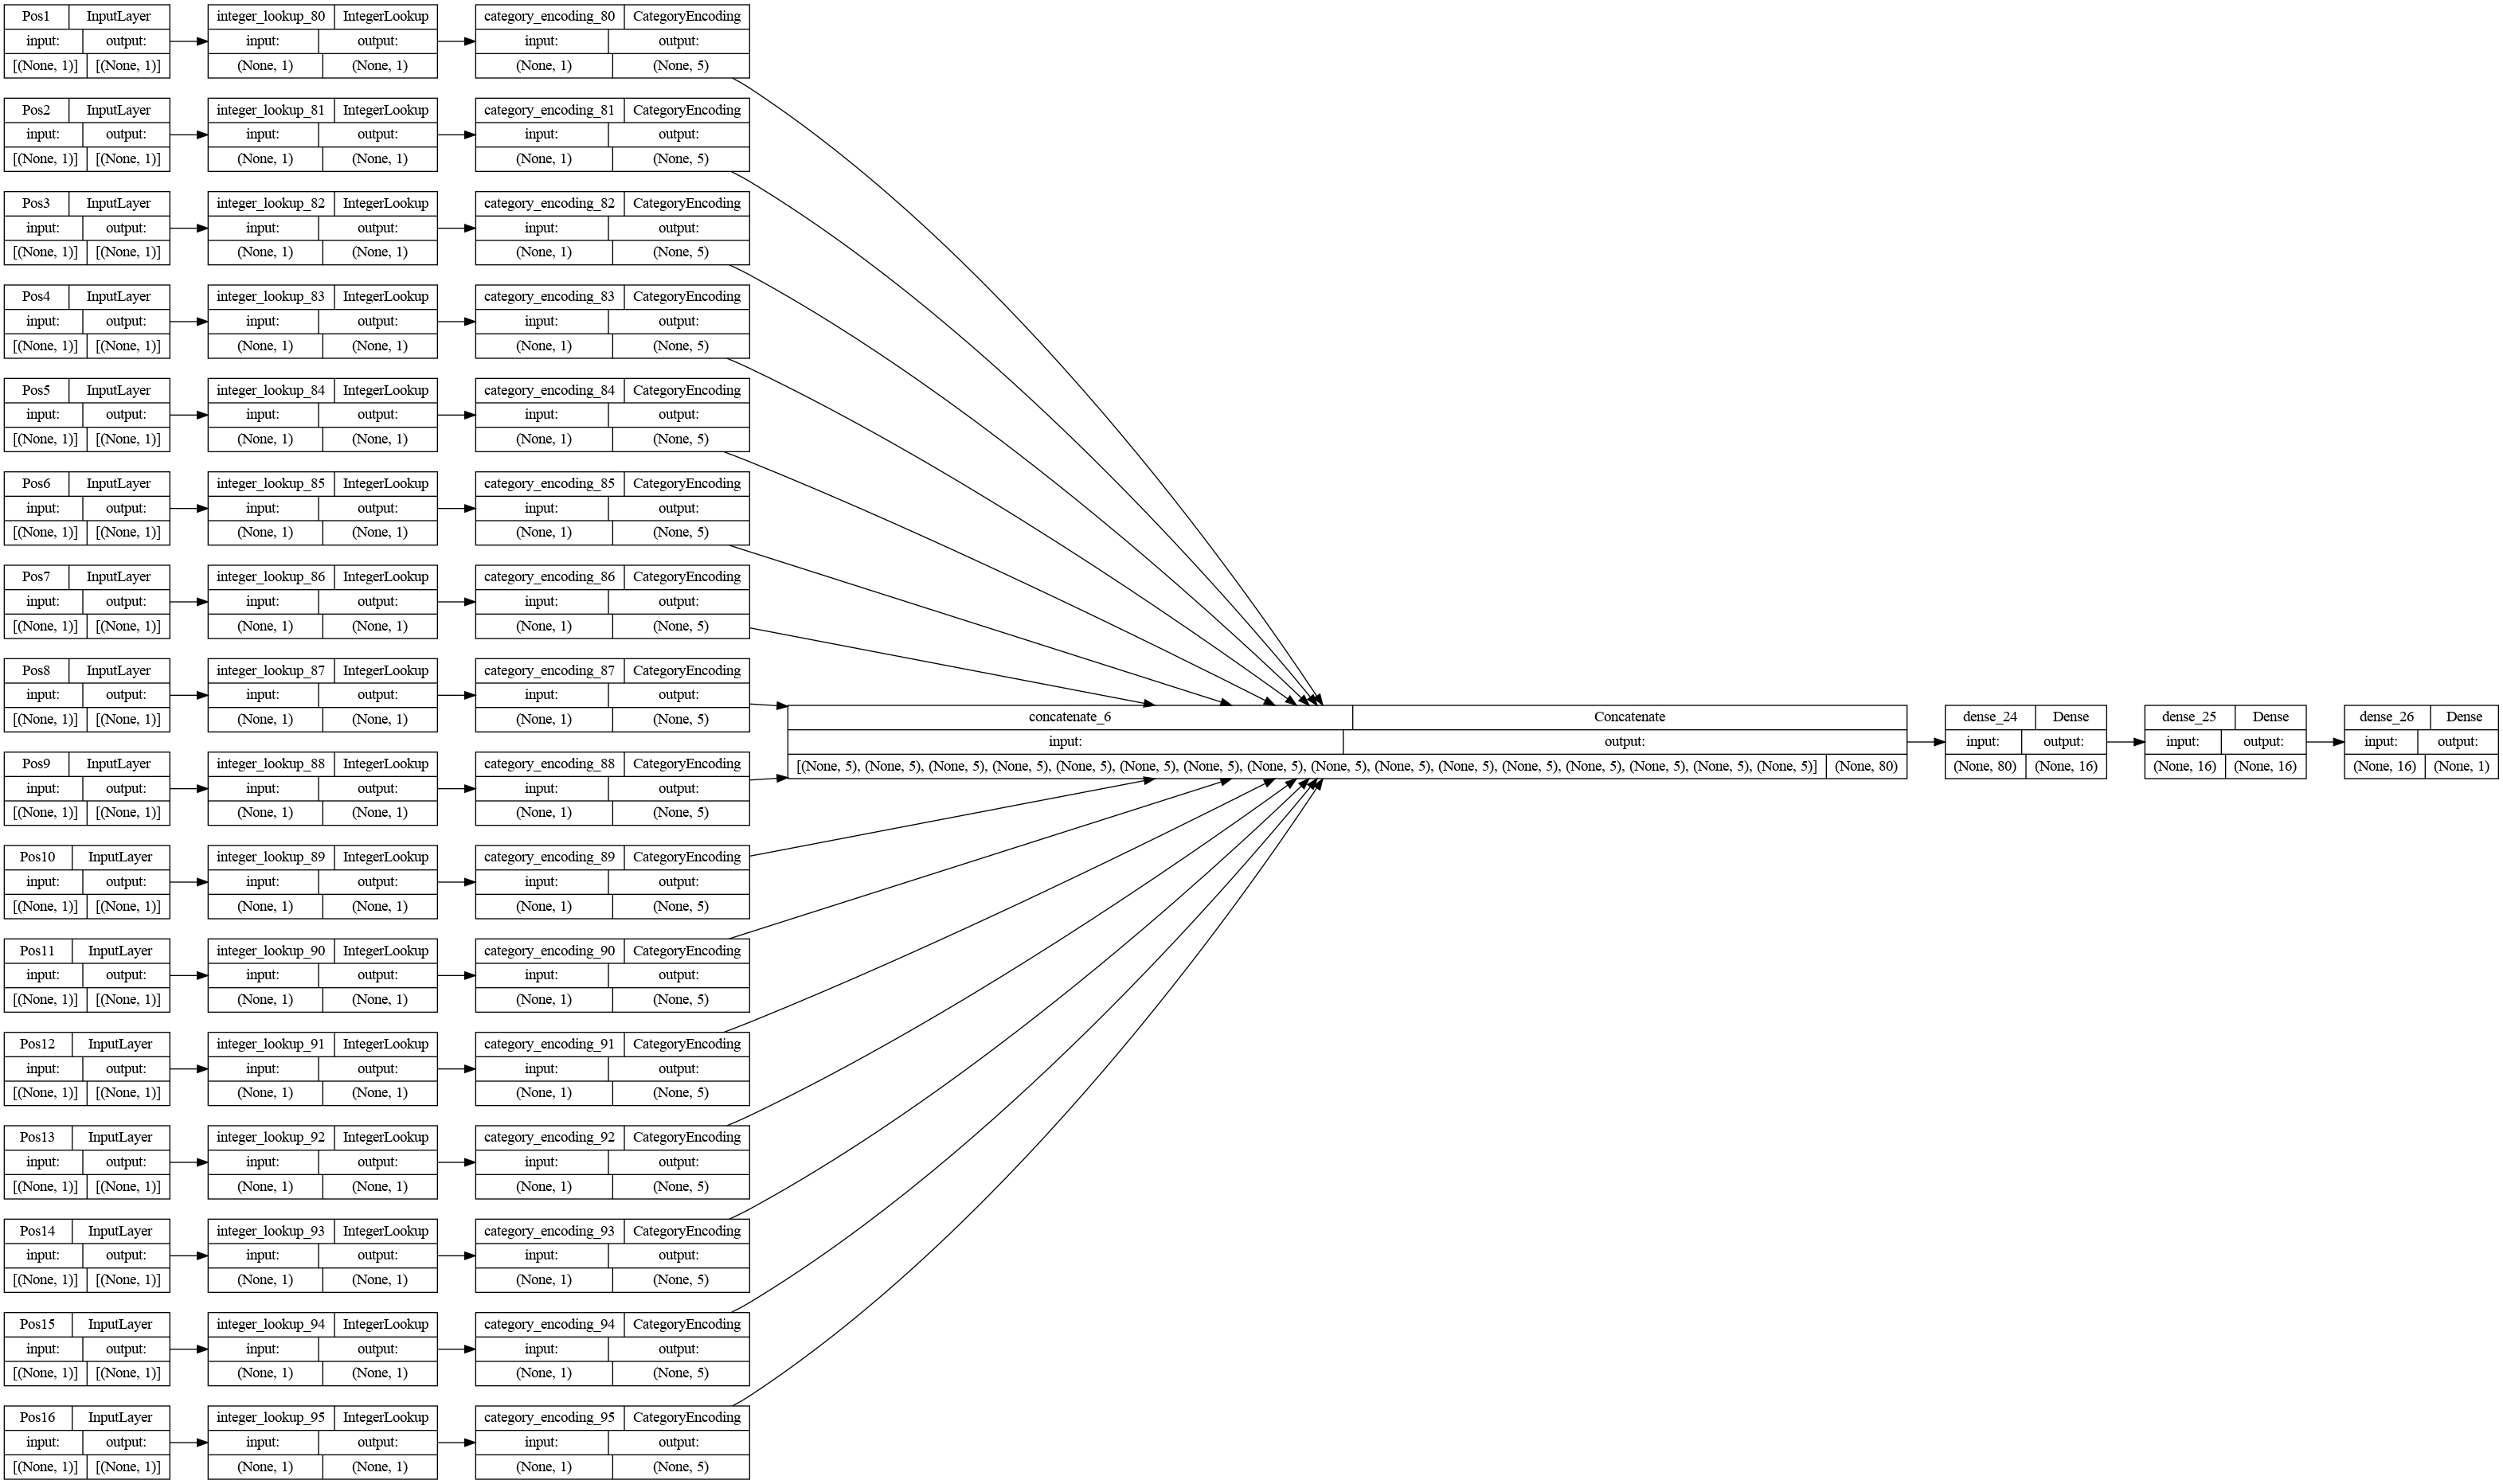

In [146]:
# Create the model architecture
all_features = tf.keras.layers.concatenate(encoded_features)

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
x = tf.keras.layers.Dense(16, activation="relu")(all_features)
x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
#x = tf.keras.layers.Dense(64, activation="relu")(all_features)
#x = tf.keras.layers.Dense(64, activation="relu")(x)
#x = tf.keras.layers.Dense(64, activation="relu")(x)

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [147]:
# Train the model
history = model.fit(train_ds, epochs=200, verbose=2, validation_data=val_ds)
#history = model.fit(train_ds, epochs=75, verbose=2, validation_data=val_ds)

Epoch 1/200


/home/alfonso/Work/UGR/Calculations/Helicenes_GNNs/Helicenes_venv/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


194/194 - 1s - loss: 0.8548 - val_loss: 0.9866 - 1s/epoch - 5ms/step
Epoch 2/200
194/194 - 0s - loss: 0.8343 - val_loss: 0.9564 - 193ms/epoch - 993us/step
Epoch 3/200
194/194 - 0s - loss: 0.8196 - val_loss: 0.9446 - 174ms/epoch - 896us/step
Epoch 4/200
194/194 - 0s - loss: 0.8069 - val_loss: 0.9345 - 175ms/epoch - 901us/step
Epoch 5/200
194/194 - 0s - loss: 0.7947 - val_loss: 0.9259 - 174ms/epoch - 898us/step
Epoch 6/200
194/194 - 0s - loss: 0.7829 - val_loss: 0.9175 - 174ms/epoch - 896us/step
Epoch 7/200
194/194 - 0s - loss: 0.7708 - val_loss: 0.9151 - 174ms/epoch - 896us/step
Epoch 8/200
194/194 - 0s - loss: 0.7585 - val_loss: 0.9108 - 173ms/epoch - 890us/step
Epoch 9/200
194/194 - 0s - loss: 0.7468 - val_loss: 0.9051 - 178ms/epoch - 919us/step
Epoch 10/200
194/194 - 0s - loss: 0.7349 - val_loss: 0.9027 - 169ms/epoch - 874us/step
Epoch 11/200
194/194 - 0s - loss: 0.7231 - val_loss: 0.8945 - 175ms/epoch - 901us/step
Epoch 12/200
194/194 - 0s - loss: 0.7113 - val_loss: 0.8880 - 173ms/e

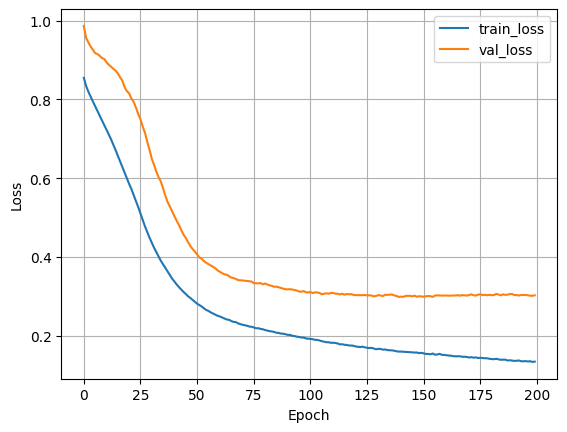

In [148]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [141]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

25/25 [==============================] - 0s 879us/step
(49, 1)
(49, 1)


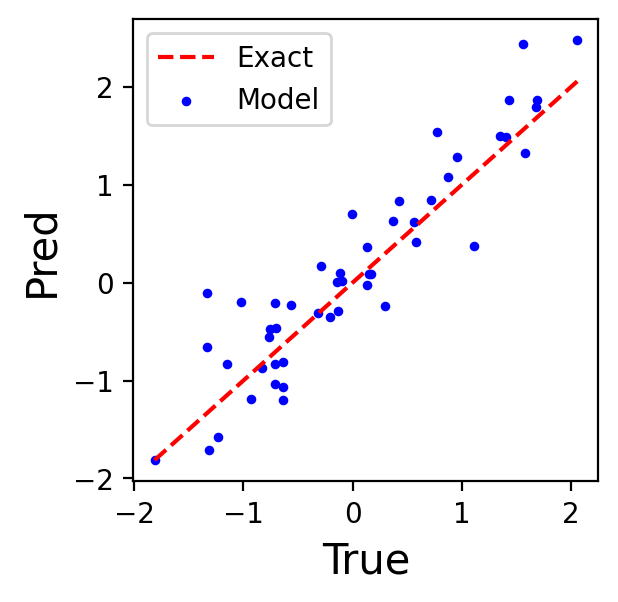

Test MAE: 0.3239294806673373


In [149]:
# Pred vs True values on test set 

y_pred = model.predict(test_ds)
y_pred.shape
y_true = np.zeros((len(test['target']),1))
y_true[:,0] = test['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

194/194 [==============================] - 0s 823us/step
(388, 1)
(388, 1)


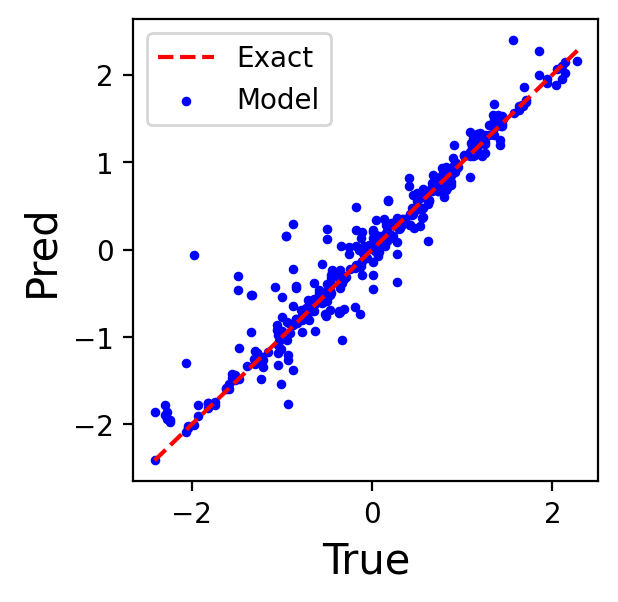

Train MAE: 0.14138372289493506


In [150]:
# Pred vs True values on training set 

y_pred = model.predict(train_ds)
y_pred.shape
y_true = np.zeros((len(train['target']),1))
y_true[:,0] = train['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae))

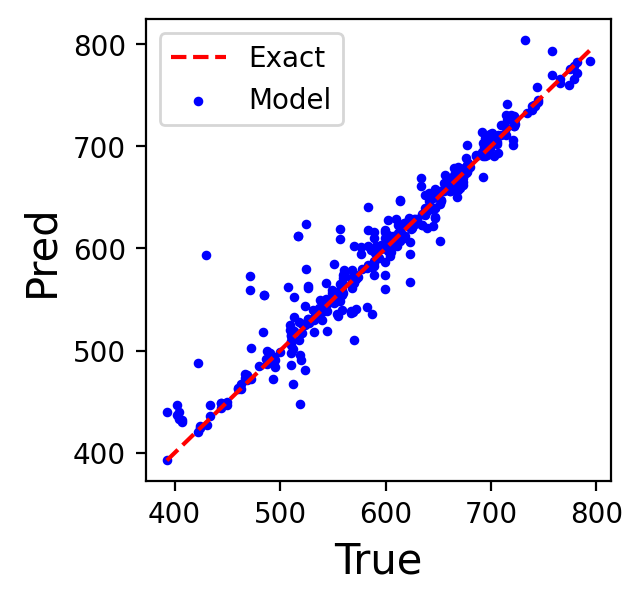

Train MAE (non-normalized): 12.091831931076838


In [151]:
# Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae))

In [65]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

INFO:tensorflow:Assets written to: R_model_good_medium/assets


INFO:tensorflow:Assets written to: R_model_good_medium/assets


25/25 [==============================] - 0s 831us/step


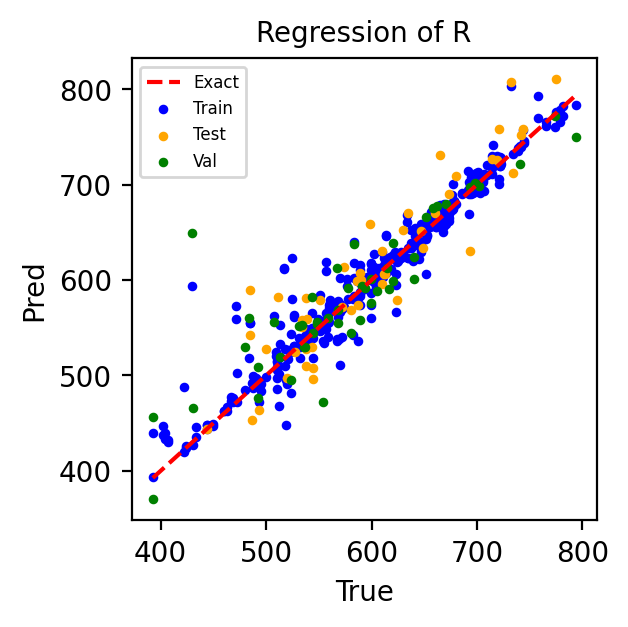

train MAE (non-normalized): 12.091831931076838
test MAE (non-normalized): 27.704044231305804
val MAE (non-normalized): 25.880551281489144


In [152]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(test_ds)
y_true_test = np.zeros((len(test['target']),1))
y_true_test[:,0] = test['target']

y_pred_train = model.predict(train_ds)
y_true_train = np.zeros((len(train['target']),1))
y_true_train[:,0] = train['target']

y_pred_val = model.predict(val_ds)
y_true_val = np.zeros((len(val['target']),1))
y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

y_true_val = y_true_val * R_std + R_mean
y_pred_val = y_pred_val * R_std + R_mean
y_true_val = y_true_val.ravel()
y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
val_mae = mean_absolute_error(y_true_val,y_pred_val)
print("val MAE (non-normalized): "+str(val_mae))

In [94]:
min(y_true_val)

314.7397

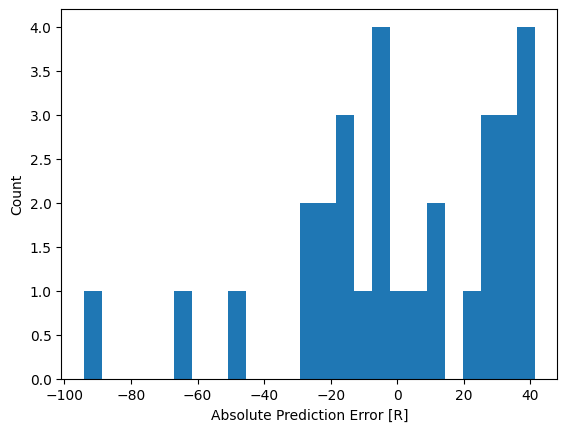

In [110]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Absolute Prediction Error [R]')
_ = plt.ylabel('Count')


In [101]:
y_pred = np.concatenate((y_pred_train,y_pred_test,y_pred_val))
y_true = np.concatenate((y_true_train,y_true_test,y_true_val))
#print(y_true.shape)
#print(y_pred.shape)
#print(y_true)
#print(y_pred)
y_true = y_true.ravel()
y_pred = y_pred.ravel()
#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

# explore data

data = dataset.to_numpy()

#print()
print("Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)")

error_nhalogens = np.zeros(4)
num_nhalogens = np.zeros(4)
error_halogentype = np.zeros(4)
num_halogentype = np.zeros(4)

for i in range(len(y_pred)):
    diff = abs(y_pred[i]-y_true[i])
    x_data = data[i,0:15]
    n_halogens = np.count_nonzero(x_data)
    #print(data[i,0:15])
    #print(n_halogens)

    error_nhalogens[n_halogens-1] = error_nhalogens[n_halogens-1] + diff
    num_nhalogens[n_halogens-1] = num_nhalogens[n_halogens-1] + 1

    print(str(i)+"  "+str(n_halogens)+"  "+str(y_true[i])+"  "+str(y_pred[i])+"  "+str(diff))


error_nhalogens[:] = error_nhalogens[:] / num_nhalogens[:]
print()
print("Mean Absolute Error (MAE) according to nº halogens: 1 halogen, 2 halogens, 3 halogens, 4 halogens")
print(error_nhalogens)

Data id, nº halogens, y_true, y_pred, abs(y_pred-y_true)
0  2  490.0979  492.01505  1.9171451660156436
1  2  694.2488  695.3562  1.1074011718750398
2  4  622.4132  612.7174  9.69579277343746
3  2  510.1173  508.46835  1.6489467285156252
4  2  723.008  713.5993  9.408695800781288
5  3  620.8228  611.1054  9.71739228515628
6  1  333.589  347.82687  14.237873779296876
7  1  599.5056  598.4112  1.0944061523437085
8  2  618.7054  618.52997  0.1754317382813042
9  4  402.5358  407.56668  5.03088090820313
10  3  611.754  605.98596  5.768038085937519
11  1  662.4751  660.79095  1.6841454101562476
12  2  673.3584  669.5583  3.8001114257812105
13  2  547.925  545.4622  2.4627807617187045
14  2  587.08  572.7919  14.288129882812541
15  2  634.9959  630.76624  4.229664648437506
16  1  611.754  604.961  6.793001464843769
17  3  614.6289  606.7772  7.851678320312544
18  4  723.008  711.16766  11.840336425781288
19  3  524.2032  519.76685  4.436354296875038
20  2  559.7055  556.01514  3.69036328125002